In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import os

# importeren van zelf geschreven modules
from Callbacks.RealTimePlotCallback import RealTimePlotCallback
from dataset_module import dataset_creation

In [2]:
while os.getcwd() != "C:\\My Projects\\Opdracht-schilders":
    os.chdir('..')

os.chdir("5. Verder experimenteren model/5.3 Optimizer & learning rate")
os.getcwd()

'C:\\My Projects\\Opdracht-schilders\\5. Verder experimenteren model\\5.3 Optimizer & learning rate'

In [3]:
classes = os.listdir("../../datasets/paintings")

In [4]:
(train_data, train_labels) = dataset_creation.create_data_with_labels("../../datasets/dataset/train/")
(val_data, val_labels) = dataset_creation.create_data_with_labels("../../datasets/dataset/validation")
(test_data, test_labels) = dataset_creation.create_data_with_labels("../../datasets/dataset/test")

..\..\datasets\dataset\train\Picasso\150.jpg --> FAILED
..\..\datasets\dataset\test\Picasso\1502.jpg --> FAILED


# Optimizer & learning rate

## ResNet met Adam als optimizer

Ik zal nu eens mijn model uittesten met Adam als optimizer.
Even ter herinnering, met mijn gekozen model met RMSprop bekom ik een **accuracy van 96.52%** en een **loss van 0.29**.

In [9]:
conv_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)

# alle lagen behalve de laatste 4 freezen
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

input_layer = keras.Input(shape=(180, 180, 3))
x = conv_base(input_layer)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(input_layer, outputs)


model.compile(loss="sparse_categorical_crossentropy",
     optimizer=keras.optimizers.Adam(learning_rate=1e-5),
     metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

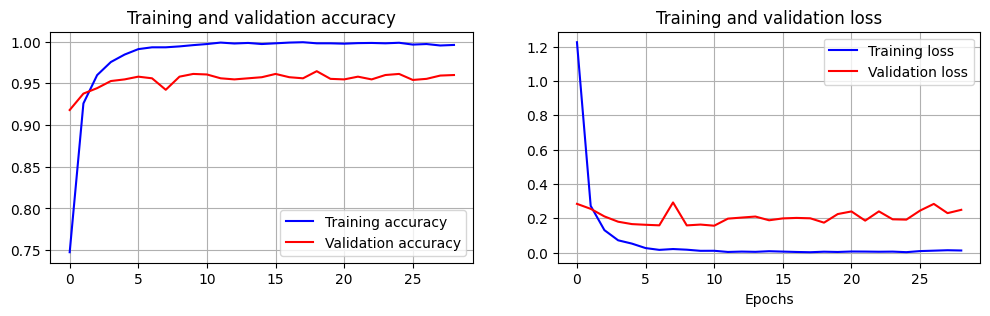

training loss: 0.012038546614348888
validation loss: 0.2490537017583847
training accuracy: 0.9960775971412659
validation accuracy: 0.9599999785423279

epochs: 29

144/144 [==============================] - 16s 110ms/step - loss: 0.0120 - accuracy: 0.9961 - val_loss: 0.2491 - val_accuracy: 0.9600


In [10]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="ResNet_Adam.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,
     monitor="val_accuracy"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_data, train_labels,
         epochs=50,
         validation_data=(val_data, val_labels),
         callbacks=callbacks_list)

We zien dat na de 10e epoch onze validatie loss terug wat begint te stijgen. Dit is een teken van overfitting, onze validatie accuracy stijgt ook niet meer na de 10 epoch.

In [11]:
model = keras.models.load_model("ResNet_Adam.keras")
model.evaluate(test_data, test_labels)

48/48 [==============================] - 5s 86ms/step - loss: 0.2039 - accuracy: 0.9626


[0.20385877788066864, 0.962598443031311]

Onze **accuracy is een heel klein beetje gedaald naar 96.26%**, maar onze loss is wel **goed gedaald naar 0.20**.

## Learning rate

Mijn originele gekozen model had een learning rate van 1e-5. Ik zal nu eens een grotere en een kleinere learning rate uitesten.

### 1e-4 (0.0001)

Ik zal eerst en vooral eens een grotere learning rate uittesten.

In [5]:
conv_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)

# alle lagen behalve de laatste 4 freezen
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

input_layer = keras.Input(shape=(180, 180, 3))
x = conv_base(input_layer)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(input_layer, outputs)


model.compile(loss="sparse_categorical_crossentropy",
     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
     metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

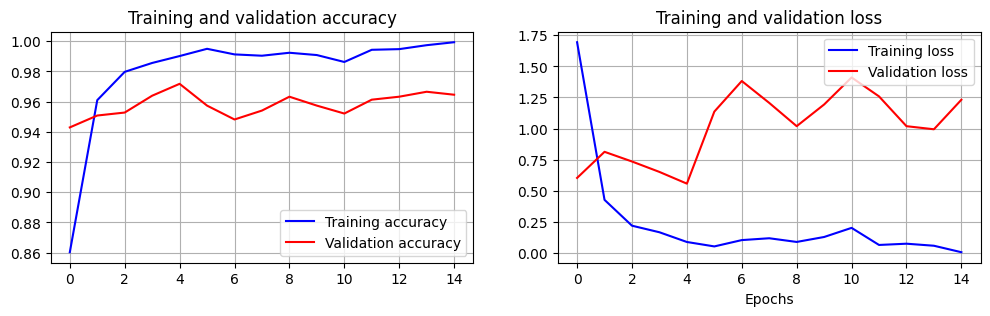

training loss: 0.005474487319588661
validation loss: 1.2317454814910889
training accuracy: 0.9993462562561035
validation accuracy: 0.9645901918411255

epochs: 15

144/144 [==============================] - 15s 105ms/step - loss: 0.0055 - accuracy: 0.9993 - val_loss: 1.2317 - val_accuracy: 0.9646


In [6]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="ResNet_Adam_1e-4.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,
     monitor="val_accuracy"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_data, train_labels,
         epochs=50,
         validation_data=(val_data, val_labels),
         callbacks=callbacks_list)

In [7]:
model = keras.models.load_model("ResNet_Adam_1e-4.keras")
model.evaluate(test_data, test_labels)

48/48 [==============================] - 5s 83ms/step - loss: 0.9072 - accuracy: 0.9580


[0.9072081446647644, 0.9580052495002747]

Met een hogere learning rate krijgen een slechtere accuracy en een veel slechtere loss. **Accuracy van 95.8%** en een **loss van 0.91**. We merken ook op dat na 4 epochs ons model met learning rate 1e-4 al overfit.

# 1e-4 data augmentation

Misschien bekomen we betere resultaten als we nu data augmentation toepassen.

In [9]:
conv_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)

# alle lagen behalve de laatste 4 freezen
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.2),
        # layers.RandomTranslation(0.2, 0.2)
    ]
)

input_layer = keras.Input(shape=(180, 180, 3))
x = data_augmentation(input_layer)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(input_layer, outputs)


model.compile(loss="sparse_categorical_crossentropy",
     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
     metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

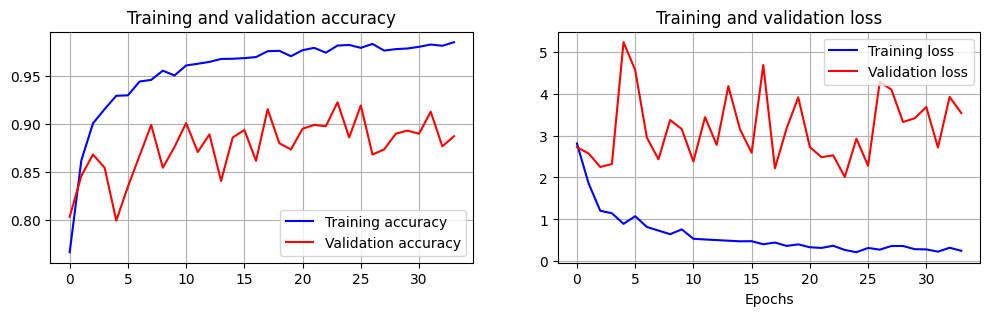

training loss: 0.2524246573448181
validation loss: 3.5379815101623535
training accuracy: 0.9851819276809692
validation accuracy: 0.8872131109237671

epochs: 34

144/144 [==============================] - 52s 359ms/step - loss: 0.2524 - accuracy: 0.9852 - val_loss: 3.5380 - val_accuracy: 0.8872


In [10]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="ResNet_Adam_1e-4_data_augmentation.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,
     monitor="val_accuracy"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_data, train_labels,
         epochs=50,
         validation_data=(val_data, val_labels),
         callbacks=callbacks_list)

We krijgen zelfs met data augmentation na een stuk of 3 epochs overfitting. Hogere learning rate kan uitgesloten worden.

In [6]:
model = keras.models.load_model("ResNet_Adam_1e-4_data_augmentation.keras")
model.evaluate(test_data, test_labels)

48/48 [==============================] - 5s 73ms/step - loss: 2.1228 - accuracy: 0.9252


[2.122769355773926, 0.9251968264579773]

Met data augmentation bekomen we een slechtere **accuracy van 92.5%** en een veel slechtere **loss van 2.12**.

### 1e-6 (0.000001)

Ik zal nu eens een kleinere learning rate van 1e-6 (0.000001) uittesten.

In [7]:
conv_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)

# alle lagen behalve de laatste 4 freezen
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

input_layer = keras.Input(shape=(180, 180, 3))
x = conv_base(input_layer)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(input_layer, outputs)


model.compile(loss="sparse_categorical_crossentropy",
     optimizer=keras.optimizers.Adam(learning_rate=1e-6),
     metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

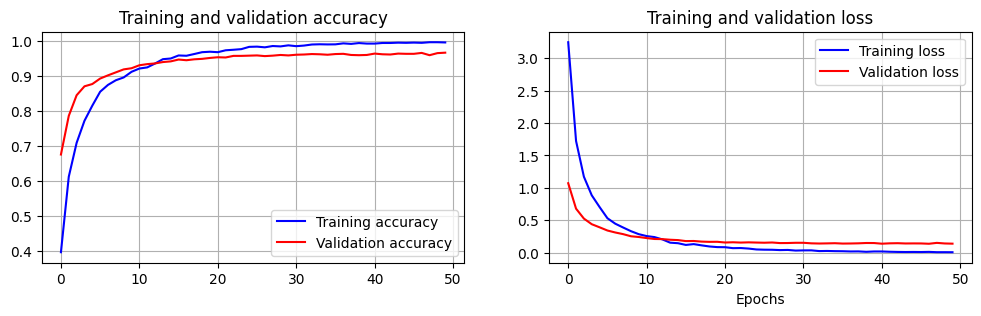

training loss: 0.0086219422519207
validation loss: 0.14057861268520355
training accuracy: 0.9965134263038635
validation accuracy: 0.9672130942344666

epochs: 50

144/144 [==============================] - 16s 110ms/step - loss: 0.0086 - accuracy: 0.9965 - val_loss: 0.1406 - val_accuracy: 0.9672


In [8]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="ResNet_Adam_1e-6.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,
     monitor="val_accuracy"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_data, train_labels,
         epochs=50,
         validation_data=(val_data, val_labels),
         callbacks=callbacks_list)

In [9]:
model = keras.models.load_model("ResNet_Adam_1e-6.keras")
model.evaluate(test_data, test_labels)

48/48 [==============================] - 5s 72ms/step - loss: 0.1787 - accuracy: 0.9600


[0.17874513566493988, 0.9599737524986267]

De **accuracy is licht gedaald naar 95.99%**, maar onze **loss is wel nog verder gedaald naar 0.179**.

### 1e-6 met RMSprop als optimizer

Ik zal nu nog eens de RMSprop optimizer uitesten met een learning rate van 1e-6.

In [10]:
conv_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)

# alle lagen behalve de laatste 4 freezen
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

input_layer = keras.Input(shape=(180, 180, 3))
x = conv_base(input_layer)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(input_layer, outputs)


model.compile(loss="sparse_categorical_crossentropy",
     optimizer=keras.optimizers.RMSprop(learning_rate=1e-6),
     metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

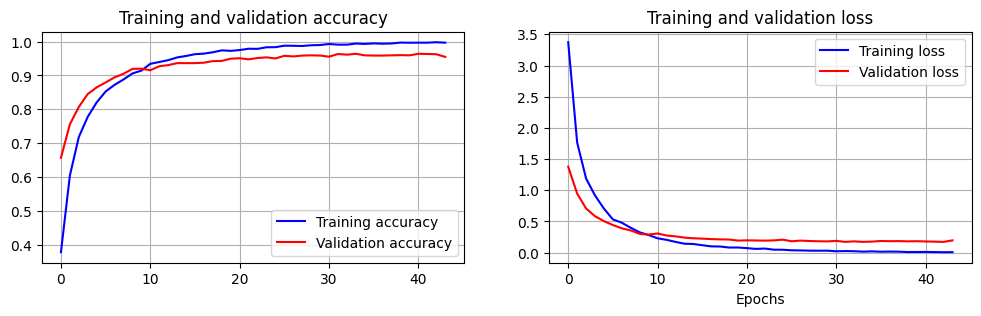

training loss: 0.008328219875693321
validation loss: 0.19708314538002014
training accuracy: 0.9967313408851624
validation accuracy: 0.954754114151001

epochs: 44

144/144 [==============================] - 16s 110ms/step - loss: 0.0083 - accuracy: 0.9967 - val_loss: 0.1971 - val_accuracy: 0.9548


In [11]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="ResNet_RMSprop_1e-6.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,
     monitor="val_accuracy"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_data, train_labels,
         epochs=50,
         validation_data=(val_data, val_labels),
         callbacks=callbacks_list)

In [12]:
model = keras.models.load_model("ResNet_RMSprop_1e-6.keras")
model.evaluate(test_data, test_labels)

48/48 [==============================] - 5s 72ms/step - loss: 0.1728 - accuracy: 0.9600


[0.1728314310312271, 0.9599737524986267]

Ik bekom identiek **dezelfde accuracy van 0.96%** als bij de Adam optimizer, maar de **loss is wel net iets lager** bij RMSprop.
Wat ik wel heb opgemerkt is dat mijn EarlyStopping na 44 epochs het RMSprop model heeft stopgezet (omdat de validatie accuracy al 10 epochs niet meer omhoog ging). Dit was niet het geval mij het Adam model.

## Verder trainen Adam model met learning rate van 1e-6

Ik zal het model met de learning rate van 1e-6 en de Adam optimizer nog wat verder laten trainen, misschien steekt deze de accuracy van RMSprop nog voorbij.

Ik zal mijn **EarlyStopping callback even verwijderen**, zodat dit model even door kan trainen.

<Figure size 640x480 with 0 Axes>

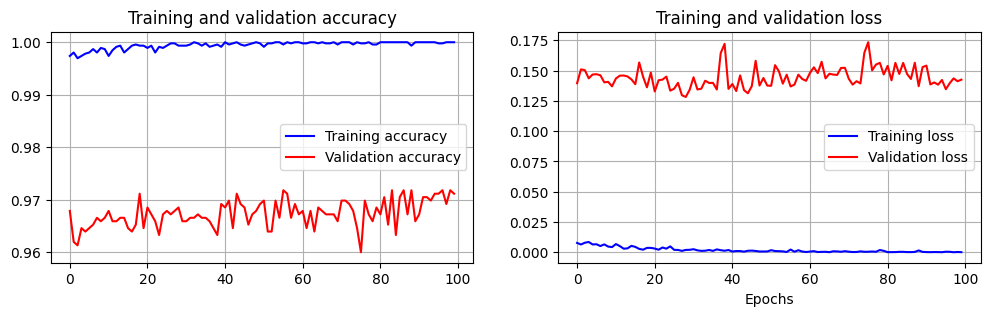

training loss: 0.00016056967433542013
validation loss: 0.14245465397834778
training accuracy: 1.0
validation accuracy: 0.9711475372314453

epochs: 100

144/144 [==============================] - 15s 104ms/step - loss: 1.6057e-04 - accuracy: 1.0000 - val_loss: 0.1425 - val_accuracy: 0.9711


In [5]:
model = keras.models.load_model("ResNet_Adam_1e-6.keras")

callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="ResNet_Adam_1e-6.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,
     monitor="val_accuracy"),
     RealTimePlotCallback()
]

history = model.fit(
         train_data, train_labels,
         epochs=100,
         validation_data=(val_data, val_labels),
         callbacks=callbacks_list)

In [6]:
model.evaluate(test_data, test_labels)

48/48 [==============================] - 4s 82ms/step - loss: 0.1996 - accuracy: 0.9619


[0.19961656630039215, 0.9619422554969788]

Na nog 100 epochs verder te trainen, bekomen we een **accuracy van 96%** en een **loss van 0.20**.
De loss is een wat groter dan bij RMSprop, maar de accuracy een beetje gestegen.


# 1e-7

Ik zal nu eens kijken of we met learning rate 1e-7 mogelijks nog betere resulaten bekomen.

In [5]:
conv_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)

# alle lagen behalve de laatste 4 freezen
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

input_layer = keras.Input(shape=(180, 180, 3))
x = conv_base(input_layer)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(input_layer, outputs)


model.compile(loss="sparse_categorical_crossentropy",
     optimizer=keras.optimizers.Adam(learning_rate=1e-7),
     metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

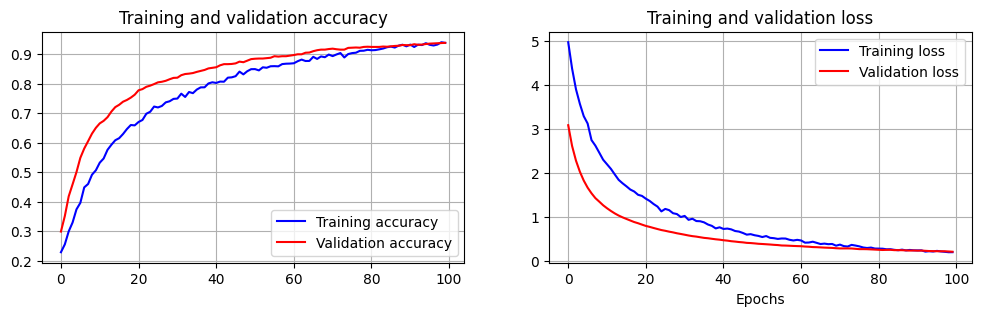

training loss: 0.20311075448989868
validation loss: 0.2131062150001526
training accuracy: 0.9376770257949829
validation accuracy: 0.9377049207687378

epochs: 100

144/144 [==============================] - 15s 103ms/step - loss: 0.2031 - accuracy: 0.9377 - val_loss: 0.2131 - val_accuracy: 0.9377


In [6]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="ResNet_Adam_1e-7.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,
     monitor="val_loss"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_data, train_labels,
         epochs=100,
         validation_data=(val_data, val_labels),
         callbacks=callbacks_list)

We zien dat de validatie accuracy en loss de trainings accuracy en loss heel goed volgt, daarom zal ik het model nog wat verder laten trainen.

In [7]:
model = keras.models.load_model("ResNet_Adam_1e-7.keras")
model.evaluate(test_data, test_labels)

48/48 [==============================] - 5s 75ms/step - loss: 0.2354 - accuracy: 0.9409


[0.23543445765972137, 0.9409449100494385]

We bekomen een **accuracy an 94%** en een **loss van 0.24**.

# Verder trainen model met learning rate 1e-7

Ik zal dit model nog wat verder laten trainen.

<Figure size 640x480 with 0 Axes>

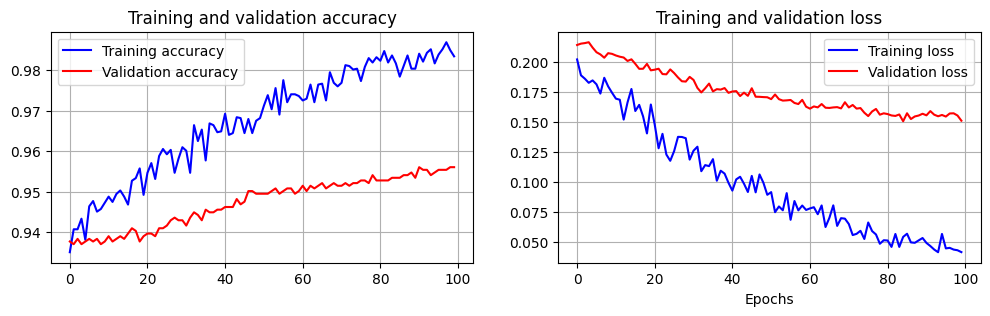

training loss: 0.04191554710268974
validation loss: 0.1510644108057022
training accuracy: 0.9834386706352234
validation accuracy: 0.9560655951499939

epochs: 100

144/144 [==============================] - 14s 98ms/step - loss: 0.0419 - accuracy: 0.9834 - val_loss: 0.1511 - val_accuracy: 0.9561


In [8]:
model = keras.models.load_model("ResNet_Adam_1e-7.keras")

callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="ResNet_Adam_1e-7_furter_training.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,
     monitor="val_loss"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_data, train_labels,
         epochs=100,
         validation_data=(val_data, val_labels),
         callbacks=callbacks_list)

We zien op de grafieken dat de validatie loss en training loss wel degelijk uit elkaar beginnen te gaan en dat de validatie loss begint te stagneren.

In [9]:
model = keras.models.load_model("ResNet_Adam_1e-7_furter_training.keras")
model.evaluate(test_data, test_labels)

48/48 [==============================] - 4s 69ms/step - loss: 0.1751 - accuracy: 0.9547


[0.17508023977279663, 0.9547244310379028]

Met een learning rate van 1e-7, bekomen we een betere loss maar een slechtere accuracy. Met de learning rate van 1e-6 bekomen we ongeveer gelijke resultaten, maar in een kortere trainingstijd (aangezien de learning rate groter is).
Daarom kies ik er dan ook voor dat 1e-6 de optimale learning rate is.

# Finale model

Als finale model kies ik het model met als optimizer Adam en met learning rate van 1e-6. Aangezien ik met een ModelCheckpoint callback werk, zal ik dit niet opnieuw moeten trainen want deze callback slaat automatisch het beste model op.

Met dit model bekwam ik een **accuracy van 96%** en een **loss van 0.17**. Dit model werd bekomen na een training van 44 epochs.

In [12]:
model = keras.models.load_model("ResNet_RMSprop_1e-6.keras")
model.evaluate(test_data, test_labels)

48/48 [==============================] - 5s 72ms/step - loss: 0.1728 - accuracy: 0.9600


[0.1728314310312271, 0.9599737524986267]